In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import netCDF4
from netCDF4 import Dataset
from scipy.interpolate import griddata

In [2]:
import matplotlib as mpl
mpl.rc('image', cmap='turbo')

In [3]:
saral = pd.read_csv('saral_mssh40.csv')
jason = pd.read_csv('jason_mssh40.csv')

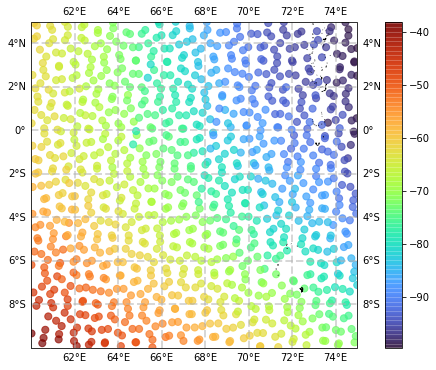

In [4]:
# Plotting the SST data on cartopy map
plt.figure(figsize=(10,6))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.coastlines(resolution='10m')
plt.scatter(saral['lon'][::10], saral['lat'][::10], c=saral['mssh'][::10], marker='o', s=50, alpha=0.7)
ax.set_extent([60, 75,-10,5], crs= ccrs.PlateCarree())
cb = plt.colorbar()
ax.gridlines(draw_labels=True, linewidth=2, alpha=0.5, linestyle='--')
plt.show()

In [5]:
# Plotting the SST data on cartopy map
plt.figure(figsize=(10,6))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.coastlines(resolution='10m')
plt.scatter(jason['lon'][::10], jason['lat'][::10], c=jason['mssh'][::10], marker='o', s=50, alpha=0.7)
ax.set_extent([60, 75,-10,5], crs= ccrs.PlateCarree())
cb = plt.colorbar()
ax.gridlines(draw_labels=True, linewidth=2, alpha=0.5, linestyle='--')
plt.show()

In [6]:
# 3 sigma test

def detect_outliers_3sigma(data):
    mean = np.mean(data)
    std = np.std(data)
    outliers = []
    for i in data:
        z_score = (i - mean) / std
        if np.abs(z_score) > 3:
            outliers.append(i)
    return outliers

# 6 MAD test

def detect_outliers_6mad(data):
    median = np.median(data)
    mad = np.median([np.abs(i - median) for i in data])
    outliers = []
    for i in data:
        modified_z_score = 0.6745 * (i - median) / mad
        if np.abs(modified_z_score) > 6:
            outliers.append(i)
    return outliers

In [7]:
# 3 sigma test on seasonal data
detect_outliers_3sigma(saral['mssh'])

[]

In [8]:
detect_outliers_6mad(saral['mssh'])

[]

In [9]:
z_score = 3*np.std(jason['mssh']) + np.mean(jason['mssh']) # 3 sigma
indices = np.where(jason['mssh'] > z_score)
jason['mssh'].iloc[indices] = np.nan

In [10]:
detect_outliers_6mad(jason['mssh'])

[]

In [8]:
data = pd.concat([saral, jason])

In [9]:
# Plotting the SST data on cartopy map
plt.figure(figsize=(10,6))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.coastlines(resolution='10m')
plt.scatter(data['lon'][::5], data['lat'][::5], c=data['mssh'][::5], marker='o', s=50, alpha=0.7)
ax.set_extent([60, 75,-10,5], crs= ccrs.PlateCarree())
cb = plt.colorbar()
ax.gridlines(draw_labels=True, linewidth=2, alpha=0.5, linestyle='--')
plt.show()

In [10]:
def create_grid(lon, lat, values, extent, sub=0.1):
    x = np.arange(extent[0], extent[1], sub)
    y = np.arange(extent[2], extent[3], sub)
    points = np.array([lon, lat]).T
    X, Y = np.meshgrid(x, y)
#     print(points)
    
    grid = griddata(points, values, (X, Y), method='linear') # Linear interpolation

    return grid

In [11]:
mss_grid = create_grid(data['lon'], data['lat'], data['mssh'], [60, 75, -10, 5])
# mss_grid = mss_grid[1:-1,1:-1]
# mss_grid

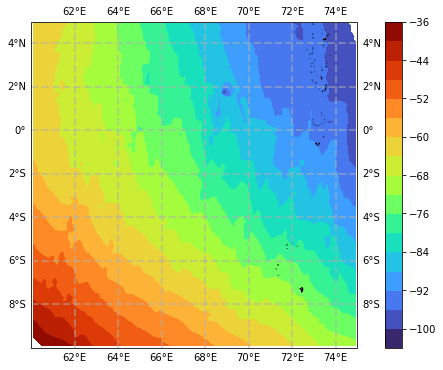

In [12]:
# Plotting the SST data on cartopy map
plt.figure(figsize=(10,6))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.coastlines(resolution='10m')
plt.contourf(np.arange(60, 75, 0.1), np.arange(-10, 5, 0.1), mss_grid, 20)
ax.set_extent([60, 75,-10,5], crs= ccrs.PlateCarree())
cb = plt.colorbar()
ax.gridlines(draw_labels=True, linewidth=2, alpha=0.5, linestyle='--')
plt.show()

### Extracting single dirn tracks

In [16]:
# Compute the track direction
import numpy as np
lat_diff = np.diff(saral['lat'])
lon_diff = np.diff(saral['lon'])
indices = [lat_diff == 0]

track_direction = np.arctan(lon_diff[~indices], lat_diff[~indices])

# Identify the crossover points
threshold = np.pi / 2.0
crossover_points = np.where(np.abs(np.diff(track_direction)) > threshold)[0]

# Create a copy of the data and replace the crossover points with NaNs
interp_data = np.copy(saral['mssh'])
interp_data[crossover_points + 1] = np.nan

TypeError: bad operand type for unary ~: 'list'

### Anisotropic filtering

In [21]:
def anisodiff(image,niter=1,kappa=0.16,gamma=0.25,step=(1,1)):
    # ...you could always diffuse each color channel independently if you
    # really want
    img = image.copy()
    mask = np.isnan(image)
    img[mask==True] = 0
    if img.ndim == 3:
        warnings.warn("Only grayscale images allowed, converting to 2D matrix")
        img = img.mean(2)

    # initialize output array
    img = img.astype('float32')
    imgout = img.copy()

    # initialize some internal variables
    deltaS = np.zeros_like(imgout)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(imgout)
    gE = gS.copy()

    for ii in np.arange(1,niter):

        # calculate the diffs i.e. gradients
        deltaS[:-1,: ] = np.diff(imgout,axis=0)
        deltaE[: ,:-1] = np.diff(imgout,axis=1)
        deltaSf=deltaS;
        deltaEf=deltaE;

        # conduction gradients (only need to compute one per dim!)
        DS = 1./(1.+(deltaSf/kappa)**2.)/step[0]
        DE = 1./(1.+(deltaEf/kappa)**2.)/step[1]

        # update matrices
        E = DE*deltaE
        S = DS*deltaS

        # subtract a copy that has been shifted 'North/West' by one
        # pixel. don't as questions. just do it. trust me.
        NS[:] = S
        EW[:] = E
        NS[1:,:] -= S[:-1,:]
        EW[:,1:] -= E[:,:-1]

        # update the image
        imgout += gamma*(NS+EW)
        print('Min: {}, Max: {}, Mean: {}'.format(imgout.min(), imgout.max(), imgout.mean()))
        print('-----------------------------------------')
        
    imgout[mask] = np.nan
    return imgout

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True, False, False, ..., False,  True,  True],
       [ True, False, False, ..., False,  True,  True],
       [ True, False, False, ...,  True,  True,  True]])

In [22]:
out = anisodiff(mss_grid, 50, kappa=50)

Min: -99.36003875732422, Max: 0.0, Mean: -71.85289764404297
-----------------------------------------
Min: -99.26215362548828, Max: 0.0, Mean: -71.85289001464844
-----------------------------------------
Min: -99.16548919677734, Max: 0.0, Mean: -71.85289764404297
-----------------------------------------
Min: -99.07554626464844, Max: 0.0, Mean: -71.85289764404297
-----------------------------------------
Min: -99.03173828125, Max: 0.0, Mean: -71.85289764404297
-----------------------------------------
Min: -98.98121643066406, Max: -0.33897313475608826, Mean: -71.85289764404297
-----------------------------------------
Min: -98.9554214477539, Max: -0.7114517688751221, Mean: -71.85289764404297
-----------------------------------------
Min: -98.92192077636719, Max: -1.3021483421325684, Mean: -71.85289001464844
-----------------------------------------
Min: -98.8991928100586, Max: -1.8907548189163208, Mean: -71.85289001464844
-----------------------------------------
Min: -98.8795242309570

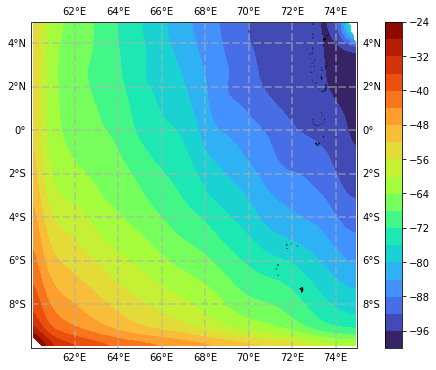

In [23]:
# Plotting the SST data on cartopy map
# out2 = mss_grid.copy()
# out2[1:,:] = out
plt.figure(figsize=(10,6))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.coastlines(resolution='10m')
plt.contourf(np.arange(60, 75, 0.1), np.arange(-10, 5, 0.1), out, 20)
ax.set_extent([60, 75,-10,5], crs= ccrs.PlateCarree())
cb = plt.colorbar()
ax.gridlines(draw_labels=True, linewidth=2, alpha=0.5, linestyle='--')
plt.show()

### Reading Geoid

In [24]:
geoiddata = pd.read_csv('geoid_grid_updated.txt', sep=",", header=None)
geoiddata.columns = ["lat", "lon", "geoid"]
# geoiddata['geoid'] *= 0.0001
geoiddata.describe()

lat            lon          geoid
count  158301.000000  158301.000000  158301.000000
mean        7.500000      62.500000     -54.010881
std        13.019258      10.132488      24.065287
min       -15.000000      45.000000    -106.250468
25%        -3.800000      53.700000     -71.698601
50%         7.500000      62.500000     -51.456543
75%        18.800000      71.300000     -34.950472
max        30.000000      80.000000      -0.167739

In [14]:
geoid_grid = create_grid(geoiddata['lon'], geoiddata['lat'], geoiddata['geoid'], [60, 75, -10, 5])

In [15]:
# Plotting the Geoid data on cartopy map
plt.figure(figsize=(10,6))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.coastlines(resolution='10m')
plt.contourf(np.arange(60, 75, 0.1), np.arange(-10, 5, 0.1), geoid_grid, 20)
ax.set_extent([60, 75,-10,5], crs= ccrs.PlateCarree())
cb = plt.colorbar()
ax.gridlines(draw_labels=True, linewidth=2, alpha=0.5, linestyle='--')
plt.show()

### Computing MDT

In [120]:
mdt_grid = mss_grid - geoid_grid
mdt_grid[np.isnan(mss_grid)==True] = np.nan

In [54]:
mss_grid.mean()

-71.85289241871115

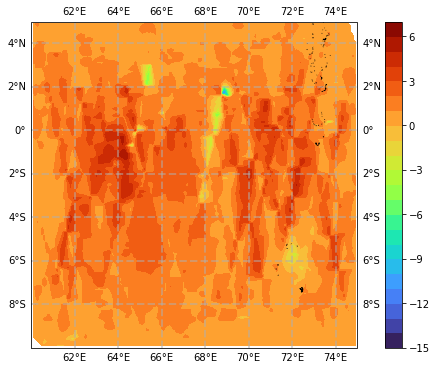

In [121]:
# Plotting the Geoid data on cartopy map
plt.figure(figsize=(10,6))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.coastlines(resolution='10m')
plt.contourf(np.arange(60, 75, 0.1), np.arange(-10, 5, 0.1), mdt_grid, 20)
ax.set_extent([60, 75,-10,5], crs= ccrs.PlateCarree())
cb = plt.colorbar()
ax.gridlines(draw_labels=True, linewidth=2, alpha=0.5, linestyle='--')
plt.show()

In [27]:
out = anisodiff(mdt_grid, 50, kappa=0.16)

Min: -14.428522109985352, Max: 5.953493118286133, Mean: 1.329317331314087
-----------------------------------------
Min: -14.424701690673828, Max: 5.902502536773682, Mean: 1.329317331314087
-----------------------------------------
Min: -14.42088794708252, Max: 5.849370956420898, Mean: 1.329317331314087
-----------------------------------------
Min: -14.417080879211426, Max: 5.793821334838867, Mean: 1.329317331314087
-----------------------------------------
Min: -14.41327953338623, Max: 5.735508918762207, Mean: 1.329317331314087
-----------------------------------------
Min: -14.4094820022583, Max: 5.6739912033081055, Mean: 1.329317331314087
-----------------------------------------
Min: -14.405686378479004, Max: 5.608678340911865, Mean: 1.329317331314087
-----------------------------------------
Min: -14.401890754699707, Max: 5.538881778717041, Mean: 1.329317331314087
-----------------------------------------
Min: -14.39809513092041, Max: 5.464761257171631, Mean: 1.329317331314087
--

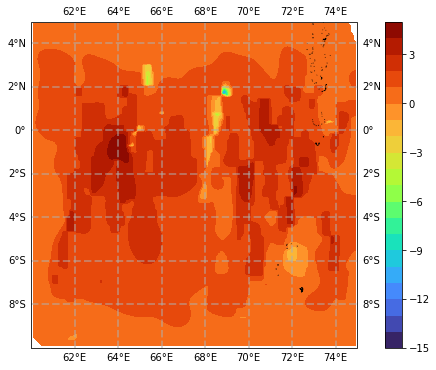

In [28]:
# Plotting the SST data on cartopy map
# mdt2 = mdt_grid.copy()
# mdt2[1:,:] = out
plt.figure(figsize=(10,6))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.coastlines(resolution='10m')
plt.contourf(np.arange(60, 75, 0.1), np.arange(-10, 5, 0.1), out, 20)
ax.set_extent([60, 75,-10,5], crs= ccrs.PlateCarree())
cb = plt.colorbar()
ax.gridlines(draw_labels=True, linewidth=2, alpha=0.5, linestyle='--')
plt.show()

### Computing Ocean Current 

In [31]:
extent = [60, 75, -10, 5]
x = np.arange(extent[0], extent[1], 0.1)
y = np.arange(extent[2], extent[3], 0.1)
X, Y = np.meshgrid(x, y)  #(lon, lat)

In [42]:
# WGS84
ELLIP = {}
ELLIP['GM'] = 3986004.418E8
ELLIP['omega'] = 7.292115e-5
ELLIP['gammaEquator'] = 978032.53359*1e-5
ELLIP['gammaPole'] = 983218.49378*1e-5
ELLIP['a'] = 6378137.0
ELLIP['b'] = 6356752.3142
ELLIP['e'] = 8.1819190842622*1e-2 #first eccentricity
ELLIP['e2'] = 6.69437999014*1e-3  #first eccentricity squared
ELLIP['f'] = 1/298.257223563       #flattening

In [43]:
def normal_gravity(lat, ellipsoid):
    pi2rad = np.pi/180
    den = np.sqrt((ellipsoid['a']*np.cos(pi2rad*lat))**2 + (ellipsoid['b']*np.sin(pi2rad*lat))**2)
    Ng = ((ellipsoid['a']*ellipsoid['gammaEquator']*(np.cos(pi2rad*lat)**2)) + (ellipsoid['b']*ellipsoid['gammaPole']*(np.sin(pi2rad*lat)**2))) / den
    return Ng


In [126]:
Ng = normal_gravity(Y, ELLIP)
f = 2*ELLIP['omega']*np.sin((np.pi/180)*Y) + 1e-6
# mdt_grid = out.copy()

In [127]:
mdt_dely = np.zeros_like(mdt_grid)
mdt_dely[1:,:] = np.diff(mdt_grid, axis=0)
mdt_delx = np.zeros_like(mdt_grid)
mdt_delx[:,1:] = np.diff(mdt_grid, axis=1)

In [132]:
u = -np.multiply(mdt_dely, Ng)/(0.1*(np.pi/180)*f*ELLIP['a'])
u[abs(u)>2000] = np.nan
v = np.multiply(mdt_delx, Ng)/(0.1*(np.pi/180)*ELLIP['a']*np.multiply(f, np.cos((np.pi/180)*Y)))
v[abs(v)>2000] = np.nan

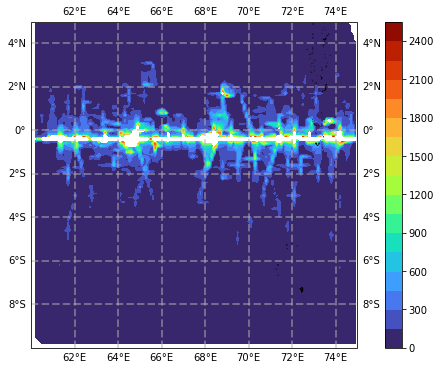

In [133]:
# Plotting the SST data on cartopy map
# mdt2 = mdt_grid.copy()
# mdt2[1:,:] = out
plt.figure(figsize=(10,6))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.coastlines(resolution='10m')
plt.contourf(np.arange(60, 75, 0.1), np.arange(-10, 5, 0.1), np.sqrt(v**2 + u**2), 20)
ax.set_extent([60, 75,-10,5], crs= ccrs.PlateCarree())
cb = plt.colorbar()
ax.gridlines(draw_labels=True, linewidth=2, alpha=0.5, linestyle='--')
plt.show()

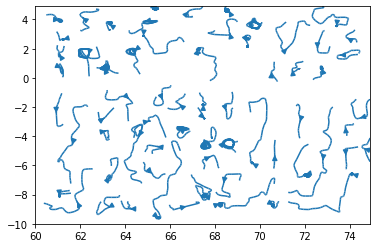

In [135]:
plt.streamplot(X, Y, u, v, density = 0.5)
plt.show()

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ..., 0.4789996 , 0.46607428,
        0.648428  ],
       [       nan,        nan,        nan, ..., 0.53053717, 0.51062363,
        0.57337973],
       ...,
       [       nan, 0.85249087, 0.87082812, ..., 0.81313639,        nan,
               nan],
       [       nan, 0.93561609, 0.96710449, ..., 0.84598228,        nan,
               nan],
       [       nan, 0.93950304, 1.01212773, ...,        nan,        nan,
               nan]])

In [72]:
mdt_dely

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,  0.05153758,
         0.04454935, -0.07504827],
       ...,
       [        nan,  0.08785362,  0.12319541, ...,  0.03037643,
                nan,         nan],
       [        nan,  0.08312522,  0.09627638, ...,  0.03284588,
                nan,         nan],
       [        nan,  0.00388696,  0.04502324, ...,         nan,
                nan,         nan]])

In [71]:
f

array([[-2.53252496e-05, -2.53252496e-05, -2.53252496e-05, ...,
        -2.53252496e-05, -2.53252496e-05, -2.53252496e-05],
       [-2.50745354e-05, -2.50745354e-05, -2.50745354e-05, ...,
        -2.50745354e-05, -2.50745354e-05, -2.50745354e-05],
       [-2.48237448e-05, -2.48237448e-05, -2.48237448e-05, ...,
        -2.48237448e-05, -2.48237448e-05, -2.48237448e-05],
       ...,
       [ 1.19501006e-05,  1.19501006e-05,  1.19501006e-05, ...,
         1.19501006e-05,  1.19501006e-05,  1.19501006e-05],
       [ 1.22037691e-05,  1.22037691e-05,  1.22037691e-05, ...,
         1.22037691e-05,  1.22037691e-05,  1.22037691e-05],
       [ 1.24574005e-05,  1.24574005e-05,  1.24574005e-05, ...,
         1.24574005e-05,  1.24574005e-05,  1.24574005e-05]])